In [1]:
%%bash
#pip install -e /home/jovyan/Tools/dea_tools
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs

Looking in indexes: https://packages.dea.ga.gov.au/


In [2]:
import csv
from pathlib import Path
import warnings

import datacube
import geopandas as gpd
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import rasterio
import rioxarray
import scipy.optimize as opt

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.waterbodies import get_time_series, get_waterbody
from dea_tools.spatial import xr_rasterize
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb
from dea_tools import filters

#import wofs.wofls
#from wofs import classifier, filters
import rioxarray


In [3]:
# Set up the datacube:
dc = datacube.Datacube(app="WaterbodyTimeSeriesS2")

In [4]:
geohash = "r4m0nb230_v3" # Lake Menindee
#ts_sa = get_time_series(geohash=geohash)

In [5]:
# Load the waterbody shape:
shape = get_waterbody(geohash)

time_period = ("2015-08-01", "2017-01-01")

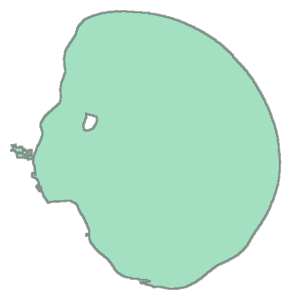

In [6]:
shape.geometry[0]

In [7]:
ds = load_ard(
    dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    resolution=(-10, 10),
    output_crs="EPSG:3577",
    min_gooddata=0.9,
    geopolygon=datacube.utils.geometry.Geometry(
        shape.geometry[0].buffer(100), crs="EPSG:3577"
    ),
    time=time_period,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 16 out of 32 time steps with at least 90.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 16 time steps


/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


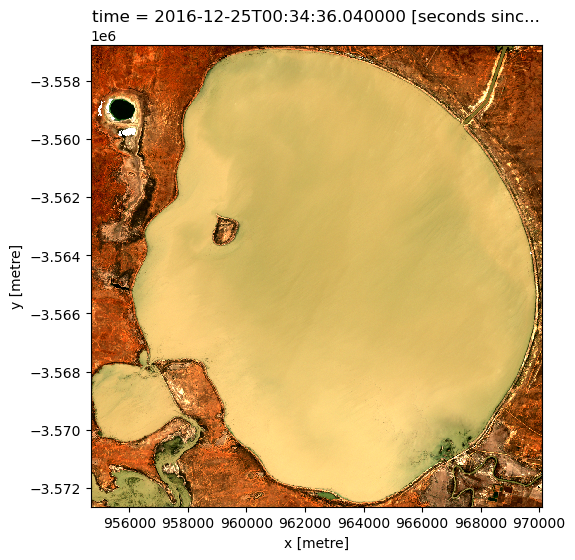

In [8]:
rgb(ds.isel(time=-1))

## Run WOfS

In [9]:
from dea_tools.S2_wofls import MASKED_CLOUD, MASKED_CLOUD_SHADOW, NO_DATA

In [10]:
# Open the DEM, which is in EPSG:3577
dem = rioxarray.open_rasterio("Menindee.tif")

# define nodata values https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html
nodata = dem.rio.nodata

In [11]:
# Screen out no-data
dem = dem.where(dem != nodata)

In [12]:
# Set zero pixels (water) to the minimum to avoid edge effects in WOfS terrain shadows
dem.isel(band=0).values[(dem == 0).values[0]] = dem.where(dem > 0).min()

In [13]:
# Convert into an xarray dataset for WOfS
dem = xr.Dataset({"elevation": dem.isel(band=0)})

In [14]:
# Set nodata attrs
ds.attrs["nodata"] = np.nan
for band in ds.variables:
    ds[band].attrs["nodata"] = np.nan

In [15]:
# and the CRS
dem.attrs["crs"] = "EPSG:3577"

In [16]:
# reproject the DEM
transform, width, height = rasterio.warp.calculate_default_transform(
    "EPSG:3577", "EPSG:3577", dem.rio.width, dem.rio.height, *dem.rio.bounds()
)

In [17]:
dem_reproj = rasterio.warp.reproject(
    source=dem.elevation,
    src_transform=dem.rio.transform(),
    src_crs=dem.crs,
    destination=ds.rename({"nbart_blue": "elevation"}).elevation.isel(time=0).copy(),
    dst_transform=ds.rio.transform(),
    dst_crs=ds.crs,
    resampling=rasterio.warp.Resampling.bilinear,
)[0]

In [18]:
# create the cloud mask
fmask = ds.oa_fmask
#print(fmask)
shape = fmask.shape
#print(shape)

def fmask_filter(fmask):
    masking = np.zeros(fmask.shape, dtype=np.uint8)
    masking[fmask == 0] += NO_DATA
    masking[fmask == 2] += MASKED_CLOUD
    masking[fmask == 3] += MASKED_CLOUD_SHADOW
    
    return masking

def spectral_bands(ds):
    bands = [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_nir_1", 
        "nbart_nir_2",
        "nbart_swir_2",
        "nbart_swir_3",
    ]
    return ds[bands].to_array(dim="band")

In [19]:
#ard = ds
#print(ard)

import numpy
import logging
import gc

try:
    import dask.array
    dask_array_type = (dask.array.Array,)
except ImportError:  # pragma: no cover
    dask_array_type = ()

from wofs import boilerplate


In [20]:
test = ds.isel(time=0)
ard = test

fmask = test.oa_fmask
print(fmask)
shape = fmask.shape
print(shape)

<xarray.DataArray 'oa_fmask' (y: 1589, x: 1541)> Size: 2MB
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)
Coordinates:
    time         datetime64[ns] 8B 2015-10-02T00:34:24.460000
  * y            (y) float64 13kB -3.557e+06 -3.557e+06 ... -3.573e+06
  * x            (x) float64 12kB 9.547e+05 9.547e+05 ... 9.701e+05 9.701e+05
    spatial_ref  int32 4B 3577
Attributes:
    units:             1
    nodata:            nan
    flags_definition:  {'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values':...
    crs:               EPSG:3577
    grid_mapping:      spatial_ref
(1589, 1541)


nbart_bands = spectral_bands(ard)
print(nbart_bands)

In [21]:
#from dea_tools.filters import eo_filter
#from dea_tools.filters import fmask_filter

water = classifier.classify(nbart_bands) \
    | eo_filter(ard) \
    | fmask_filter(ard.oa_fmask)

In [ ]:
print(water)

In [23]:
water.plot()

NameError: name 'water' is not defined

In [ ]:
from dea_tools.plotting import plot_wo

In [ ]:
plot_wo(water)

In [ ]:
def woffles_ard(ard, dsm, dsm_no_data=-1000, ignore_dsm_no_data=False):
    """Generate a Water Observation Feature Layer from ARD (NBART and FMASK) and surface elevation inputs."""
    nbar_bands = spectral_bands(ard)
    water = classifier.classify(nbar_bands) \
        | eo_filter(ard) \
        | fmask_filter(ard.fmask)

    if dsm is not None:
        # terrain_filter arbitrarily expects a band named 'blue'
        water |= terrain_filter(
            dsm,
            ard.rename({"nbart_blue": "blue"}),
            no_data=dsm_no_data,
            ignore_dsm_no_data=ignore_dsm_no_data
        )

    _fix_nodata_to_single_value(water)

    assert water.dtype == np.uint8

    return water

In [ ]:
s2_wofls = []
for i in tqdm(range(len(ds.time))):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s2_wofls_ = wofs.wofls.woffles_ard(
            ds.rename(
                {
                    "nbart_nir_1": "nbart_nir",
                    "nbart_swir_2": "nbart_swir_1",
                    "nbart_swir_3": "nbart_swir_2",
                }
            ).isel(time=i),
            xr.Dataset({"elevation": dem_reproj}, attrs={"crs": "EPSG:3577"}),
        )
        s2_wofls.append(s2_wofls_)